In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import skew
import math

from sklearn.linear_model import Ridge, Lasso

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from utils.dataManagers.dataSteward import DataSteward
from utils.dataManagers.informations import informer
from utils.predictions import *
from utils.dataManagers.dataWrangler import *
from utils.ClassifierResults import RegressionResults

ds = DataSteward('mapper_and_most_frequent', 'mean')
column_desc = informer.get_column_descriptions()

train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

Standardization can be more practical for many machine learning algorithms. The reason is that many linear
models, such as the logistic regression and SVM initialize the weights to 0 or small random values close to 0. 
Using standardization, we center the feature columns at mean 0 with standard deviation 1 so that the feature columns take the form of
a normal distribution, which makes it easier to learn the weights. Furthermore, standardization maintains useful information about outliers and makes the
algorithm less sensitive to them in contrast to min-max scaling, which scales the data to a limited range of values.

In [2]:
from scipy.stats import skew
number_type = get_number_types(train)

skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= .75].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)

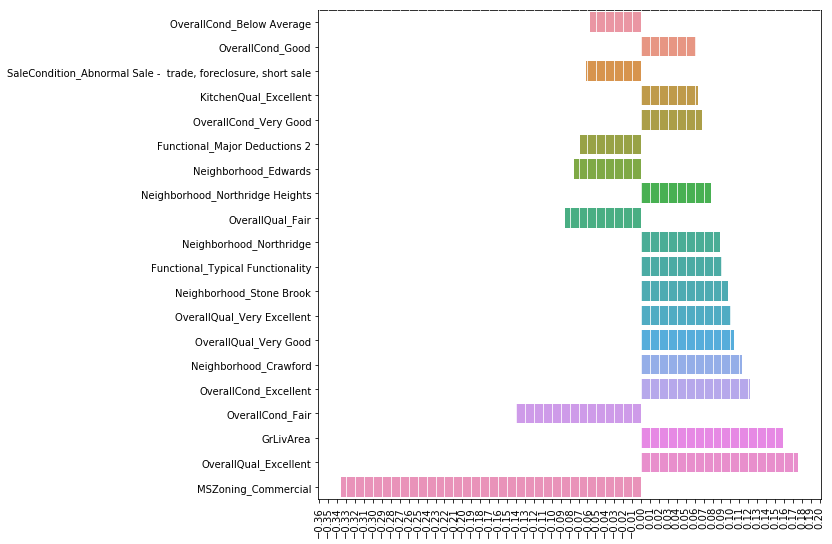

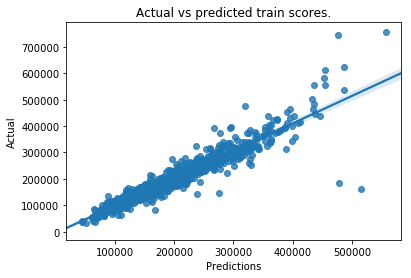

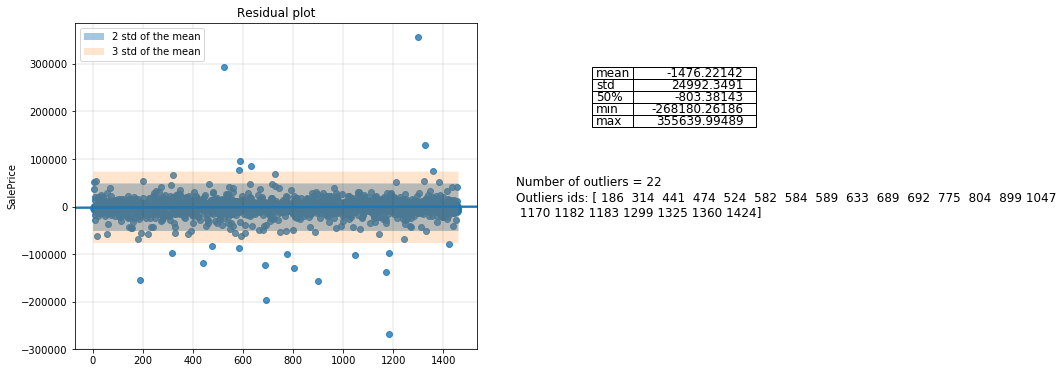

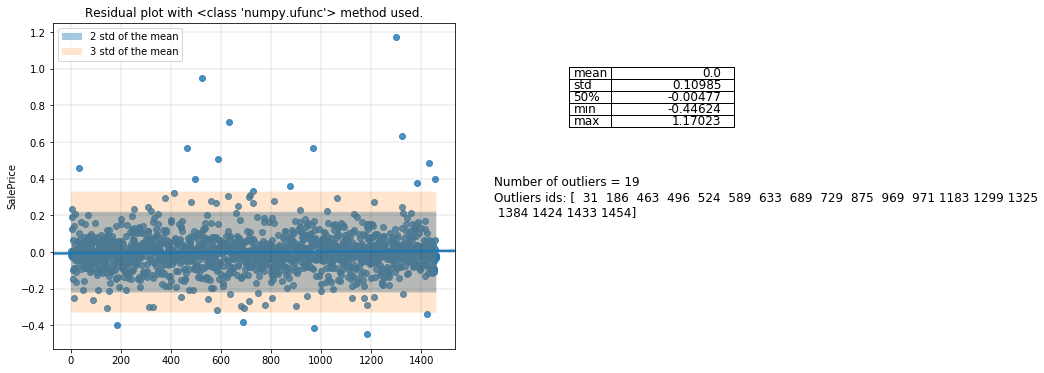

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


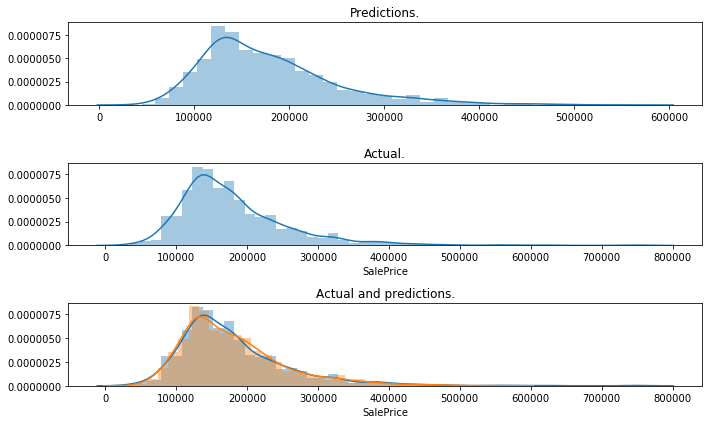

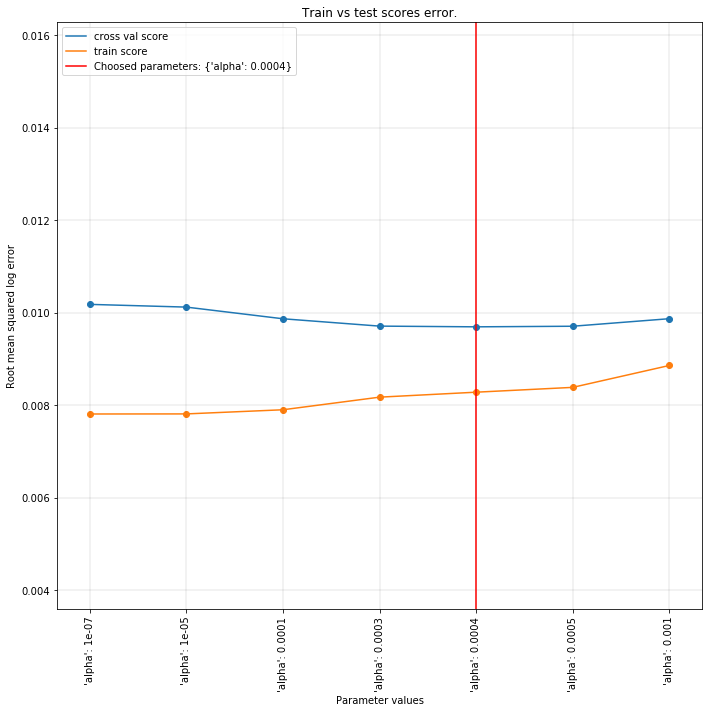

In [3]:
# alphas = [0.001, 0.01, 0.03, .1, .3, .5, 1, 3, 5, 7, 10]
alphas = [1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3]
# alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# alphas = [10, 15, 30, 50, 75, 100, 110, 115, 120, 130, 150, 175]
param_grid = dict(alpha=alphas)

results = predict(RegressionResults, Lasso(normalize=False, max_iter=5000), param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'lasso_loged_skewed_by_algo_columns_data_standarized_ytrain_logged',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

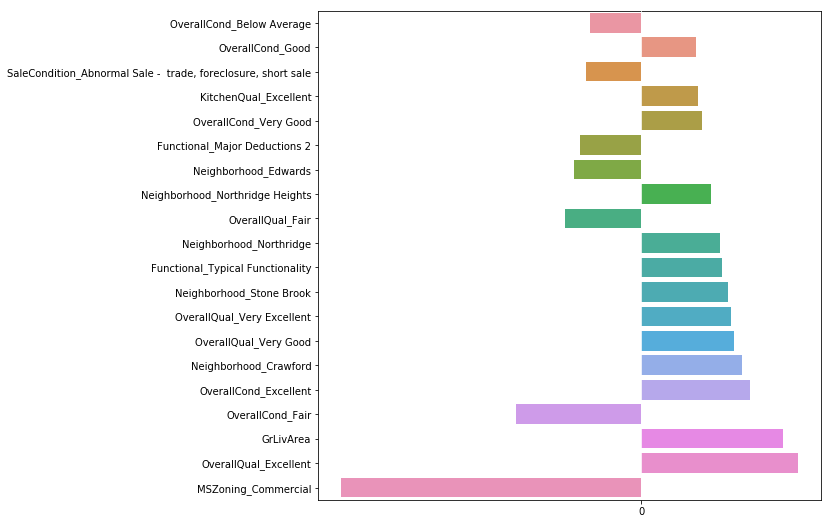

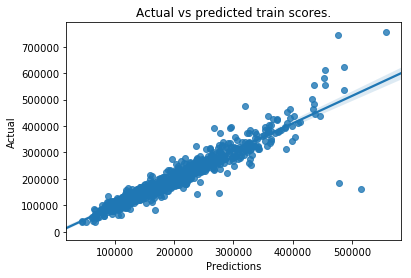

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


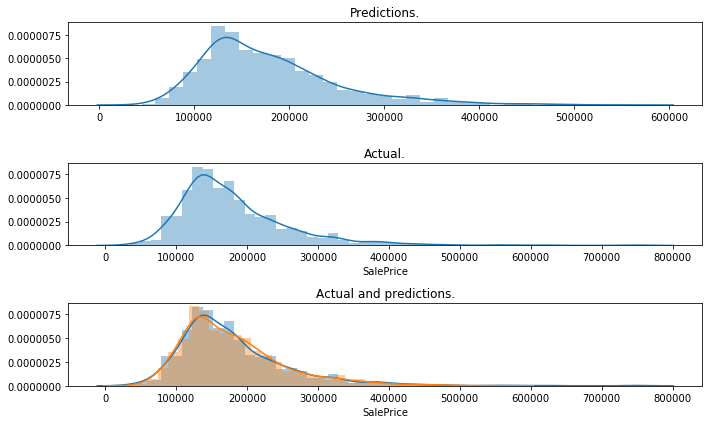

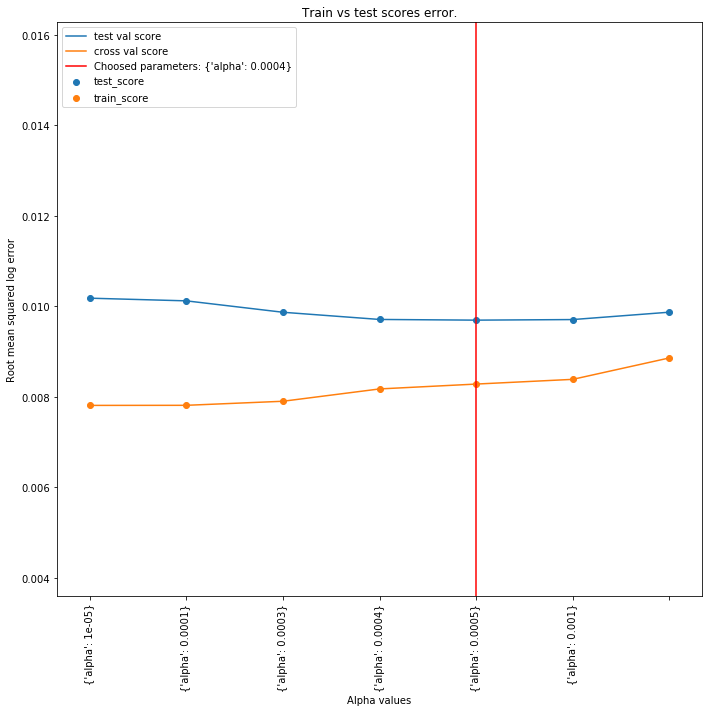

In [2]:
from scipy.stats import skew
number_type = get_number_types(train)

skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= .75].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)

# alphas = [0.001, 0.01, 0.03, .1, .3, .5, 1, 3, 5, 7, 10]
alphas = [1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3]
# alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# alphas = [10, 15, 30, 50, 75, 100, 110, 115, 120, 130, 150, 175]
param_grid = dict(alpha=alphas)

results = predict(RegressionResults, Lasso(normalize=False, max_iter=5000), param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'lasso_loged_skewed_by_algo_columns_data_standarized_ytrain_logged',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

In [8]:
df = train.copy()
df['SalePrice'] = ytrain
corr = df.corr()

sale_price_corrs = corr.SalePrice
del corr['SalePrice']

In [9]:
def calculate_corr_rank_power(row):
    name = row.name
    corr_rank[name] = sale_price_corrs[name] / (np.sum(np.power(row.values, 2)) - 1)

def calculate_corr_rank_abs(row):
    name = row.name
    corr_rank[name] = sale_price_corrs[name] / (np.sum(np.abs(row.values)) - 1)
    
corr_rank = dict()
_ = corr.apply(calculate_corr_rank_abs, axis=1)

In [48]:
# corr_rank = dict()
# _ = corr.apply(calculate_corr_rank_power, axis=1)

In [10]:
best_corrs = np.abs(pd.Series(corr_rank))
best_corrs = best_corrs[best_corrs > np.median(best_corrs)]
if 'SalePrice' in best_corrs:
    del best_corrs['SalePrice']
best_corrs

1stFlrSF        0.077519
Fireplaces      0.087346
FullBath        0.076703
GarageArea      0.082423
GarageCars      0.083489
GarageYrBlt     0.077534
GrLivArea       0.079233
LotArea         0.077127
LotFrontage     0.072341
MasVnrArea      0.089053
OpenPorchSF     0.074233
TotRmsAbvGrd    0.072113
TotalBsmtSF     0.079471
WoodDeckSF      0.080053
YearBuilt       0.077762
YearRemodAdd    0.088816
dtype: float64

In [11]:
my_pick = ['Neighborhood', 'TotalBsmtSF', 'Heating', 'HeatingQC', 
               'BsmtFinType1', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageFinish', 'HouseStyle', 'MSSubClass']

#removing duplicates with set
best_columns = list(set(list(best_corrs.index) + my_pick))
len(best_columns)

26

In [12]:
def get_number_and_categoricals(df):
    return df.select_dtypes(['int64', 'float64']), df.select_dtypes(['category']) 

def get_skeved_columns(df, skew_threshold=1):
    skewness = df.apply(lambda x: skew(x))
    mask = np.abs(skewness.sort_values()) >= 1
    return mask[mask].index

def perform_data_transformations(df, columnsSubset, colsToLog):
    number_type, categorical_type = get_number_and_categoricals(df[columnsSubset])
    colsToLog_subset = [c for c in colsToLog if c in best_columns]
    
    number_type = number_type.join(number_type[colsToLog_subset].apply(np.log1p), rsuffix='_log1p')
    number_type.drop(colsToLog_subset, axis=1, inplace=True)
    return number_type.join(categorical_type)

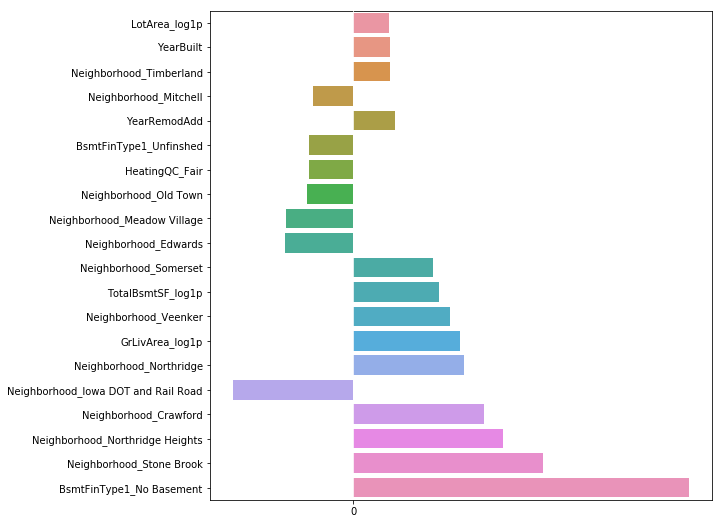

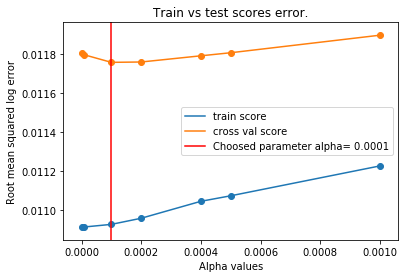

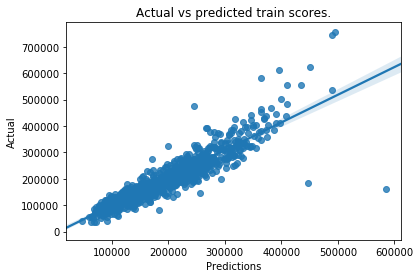

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


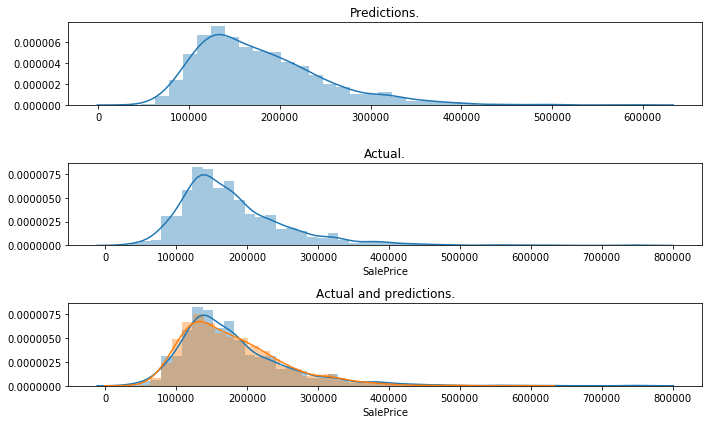

In [15]:
train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

number_type = get_number_types(train)
colsToLog = get_skeved_columns(number_type, .75)
trainTransformed = perform_data_transformations(train, best_columns, colsToLog)
testTransformed = perform_data_transformations(test, best_columns, colsToLog)

trainWithDummies, testWithDummies = get_df_for_predictions(trainTransformed, testTransformed)

alphas = [1e-7, 1e-5, 1e-4, 2e-4, 4e-4, 5e-4, 1e-3]
# alphas = [1e-7, 1e-5, 1e-4, 1e-3, 3e-3, 4e-3, 5e-3, 1e-2]
# alphas = [0.001, 0.01, 0.03, .1, .3, .5, 1, 3, 5, 7, 10]
# alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# alphas = [10, 15, 30, 50, 75, 100, 110, 115, 120, 130, 150, 175]
param_grid = dict(alpha=alphas)

results = predict(Lasso(normalize=False, max_iter=5000), param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'lasso_loged_skewed_by_algo_columns_data_standarized_ytrain_logged',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

In [175]:
%%timeit
from sklearn.model_selection import cross_val_score
grid = GridSearchCV(Lasso(normalize=False), param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
cv_score = cross_val_score(grid, trainWithDummies, np.log1p(ytrain), scoring='neg_mean_squared_error', cv=5,  n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_score), np.std(cv_score)))

7.98 s ± 78.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error

def predict_with_kfold(results_class, model, param_grid, X=trainWithDummies, y=np.log1p(ytrain), test=testWithDummies, folds=5, yield_progress=True):
    kf = KFold(n_splits=folds, random_state=None, shuffle=False)
    errs = []
    res = []
    for train_index, test_index in kf.split(trainWithDummies):
        if yield_progress:
            print(f'iteration: {len(errs)} for class {type(model)}')
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        results = predict(results_class, model, param_grid, X_train,
                            np.log1p(y_train), test, name=None,
                            predictions_form_restoring_method=restore_predictions_from_log1p,
                            plot_results=False)
        errs.append(mean_squared_log_error(results.grid.predict(X_test), np.log1p(y_test)))
        res.append(results)
    errors = pd.Series(np.sqrt(errs))
    best_result_indx = errors.argmin()
    best_result = res[best_result_indx]
    best_result.refit(X, y)
    if yield_progress:
        print(f'Best test error for model: {type(model)} is: {errors.min()}')
    return best_result

In [4]:
lasso_param_grid = dict(alpha=[1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3])
lasso_results = predict_with_kfold(RegressionResults, Lasso(normalize=False, max_iter=5000), lasso_param_grid)

iteration: 0 for class <class 'sklearn.linear_model.coordinate_descent.Lasso'>
iteration: 1 for class <class 'sklearn.linear_model.coordinate_descent.Lasso'>
iteration: 2 for class <class 'sklearn.linear_model.coordinate_descent.Lasso'>
iteration: 3 for class <class 'sklearn.linear_model.coordinate_descent.Lasso'>
iteration: 4 for class <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Best test error for model: <class 'sklearn.linear_model.coordinate_descent.Lasso'> is: 0.0024693623684553254


In [496]:
from matplotlib import gridspec

def plot_residuals(diff, y):
    fig = plt.figure(figsize=[10,6])
    gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=[2, 1, 1]) 
    ax = plt.subplot(gs[:, :-1])
    
    sns.regplot(diff.index.values, diff, ax=ax)
    diff_mean = diff.mean()
    diff_std = diff.std()
    outliers = diff[(diff > diff_mean + 3 * diff_std) | (diff < diff_mean - 3 * diff_std)]

    ax.fill_between(diff.index.values, diff_mean + 2 * diff_std, diff_mean - 2 * diff_std, alpha=.4, label='2 std of the mean')
    ax.fill_between(diff.index.values, diff_mean + 3 * diff_std, diff_mean - 3 * diff_std, alpha=.2, label='3 std of the mean')
    diff.describe().round(5)
    ax.legend()
    ax.set_title(f'Residual plot.')
    ax.grid(color='black', linestyle='-', linewidth=.1)
    
    ax = plt.subplot(gs[0, -1])
    ax.axis('off')
    diff_info = diff.describe()[['mean', 'std', '50%', 'min', 'max']].round(5).to_frame()
    table = ax.table(cellText=diff_info.values.astype('str'), rowLabels=diff_info.index.values, loc='right')
    table.set_fontsize(12)
    
    ax = plt.subplot(gs[1, -1])
    ax.axis('off')
    ax.text(.05, .9, f'Number of outliers = {outliers.count()}\nOutliers ids: {outliers.index.values}', fontsize=12)
    

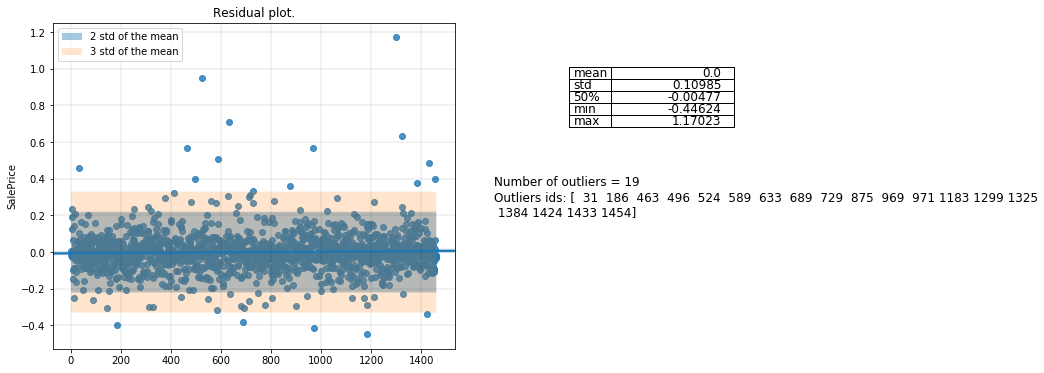

In [497]:
y = np.log1p(ytrain)
diff = pd.Series(lasso_results.train_predictions - y)
plot_residuals(diff, y)

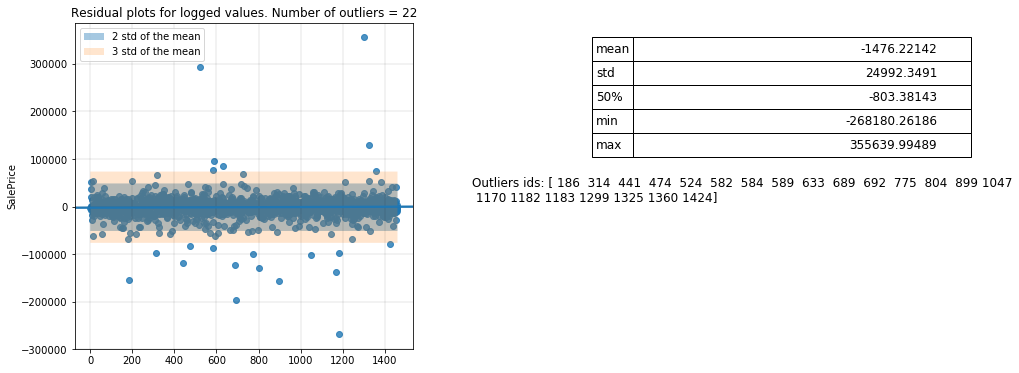

In [353]:
y = ytrain
diff = pd.Series(np.expm1(lasso_results.train_predictions) - y)
plot_residuals(diff, y)

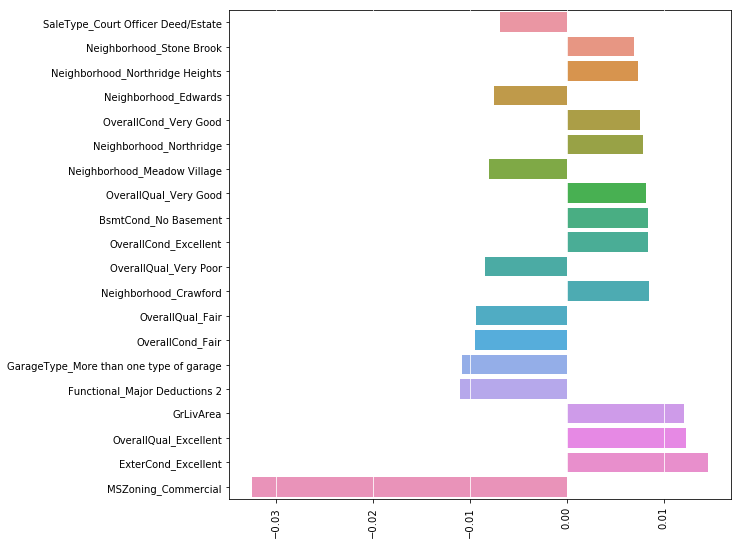

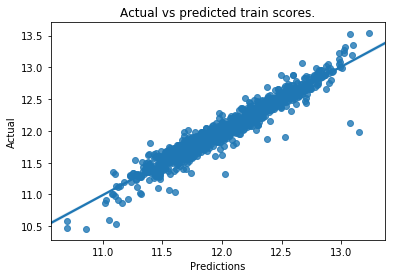

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


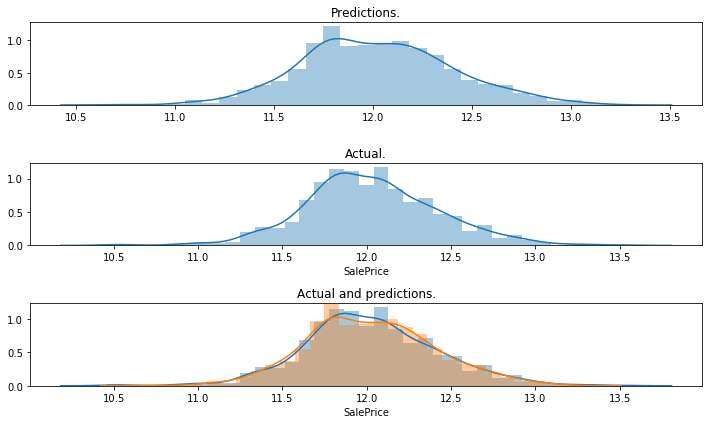

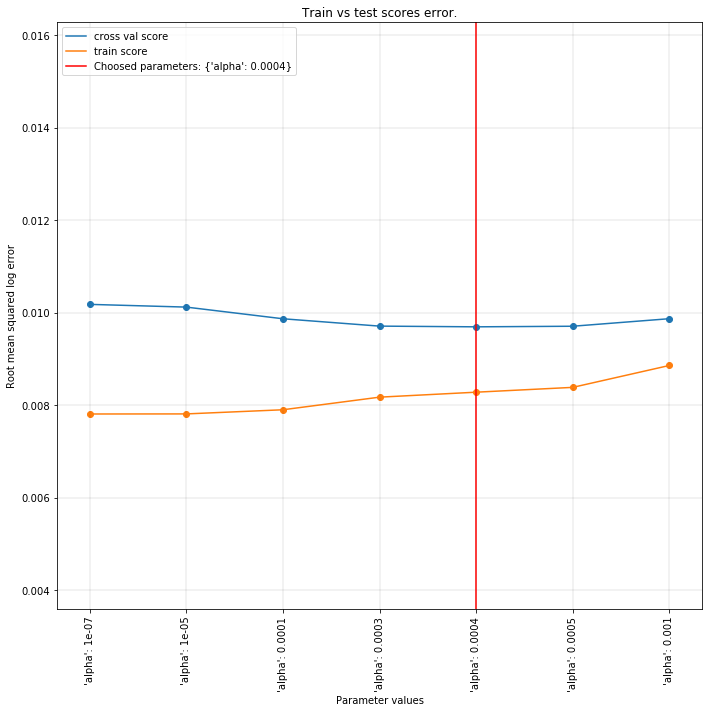

In [7]:
lasso_results.plot_results()

If we analyze train subset Train vs test scores plots we can see that when it comes to lasso they are pretty close to each other in all cases. We have a high bias problem, possible solutions are:
* add new features,
* add polynomial features,
* decrease lambda parameter.

When i submit this solution to kaggle i get result about .134 err rate which is much higher than err rate on train set (0.0085), so we have high variance problem. Possible solutions are:
* getting more training data,
* trying smaller subset of features,
* increasing of lambda parameter.

Difference in results submitted to kaggle is bigger than those in train subset analysis so I will focus on dealing with high variance problem first.
Here I could plot model score vs training set size but since I can't get more training data, whats left is to try to do some feature engineering and try to tune lambda parameter better.


In [221]:
train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

number_type = get_number_types(train)

skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= .75].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)

In [180]:
from sklearn.utils import resample

def get_reliable_coef(model, X, y, iters=1000):
    coefs = []
    for _ in range(iters):
        coefs.append(model.fit(*resample(X, y)).coef_)
    df = pd.DataFrame(coefs)
    df.columns = trainWithDummies.columns
    return df

coefs = get_reliable_coef(Lasso(alpha=.0004, normalize=False, max_iter=5000), trainWithDummies, np.log1p(ytrain))    
coefs.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_Contract Low Down,SaleType_Contract Low Down payment and low interest,SaleType_Contract Low Interest,SaleType_Court Officer Deed/Estate,SaleType_Home just constructed and sold,SaleType_Other,SaleType_WD,SaleType_Warranty Deed - Cash,Street_Gravel,Street_Paved
0,0.002867,0.027188,0.023278,0.020118,-0.016353,0.029335,-0.005252,-0.002965,0.022424,-0.000000,...,0.000000,-0.0,-0.0,-0.041039,0.002121,0.000000,-0.058877,-0.0,0.0,-0.0
1,0.001943,0.038744,0.042447,0.011468,-0.004367,0.022994,-0.001684,-0.005614,0.024462,0.022018,...,0.000000,-0.0,0.0,-0.020259,0.000000,0.021824,-0.033373,0.0,-0.0,0.0
2,0.008261,0.038675,0.033138,0.015456,-0.002282,0.031089,-0.001918,-0.002701,0.015482,0.033136,...,0.004845,-0.0,-0.0,-0.000000,0.029940,0.000000,-0.018755,0.0,-0.0,0.0
3,-0.004831,0.029410,0.040185,0.014696,-0.000000,0.023666,-0.004963,-0.008922,0.021770,0.000000,...,0.000000,0.0,0.0,-0.000000,0.000000,0.000000,-0.027450,0.0,-0.0,0.0
4,0.003178,0.042573,0.058262,0.011911,-0.000820,0.018459,0.003868,-0.010411,0.035690,0.007875,...,0.000000,-0.0,-0.0,-0.000000,0.051139,0.000000,-0.028346,0.0,-0.0,0.0


In [188]:
df = pd.DataFrame([coefs.mean(), coefs.std()]).T
df.columns = ['coef_mean', 'coef_std']
df['abs_coef_mean'] = np.abs(df.coef_mean)
df = df.sort_values(by='abs_coef_mean', ascending=False).round(5)
df.head()

best_85_quantile_cols = df[df.abs_coef_mean > df.abs_coef_mean.quantile(.85)].index

,coef_mean,coef_std,abs_coef_mean
MSZoning_Commercial,-0.31267,0.10243,0.31267
OverallQual_Excellent,0.16640,0.02907,0.16640
GrLivArea,0.15163,0.01488,0.15163
OverallCond_Fair,-0.13797,0.03750,0.13797
Neighborhood_Crawford,0.10926,0.01993,0.10926


In [206]:
lasso_param_grid = dict(alpha=[1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3])
lasso_cols_selected = predict_with_kfold(RegressionResults, Lasso(normalize=False, max_iter=7000), lasso_param_grid, X=trainWithDummies.loc[:, best_85_quantile_cols], test=testWithDummies.loc[:, best_85_quantile_cols])

iteration: 0 for class <class 'sklearn.linear_model.coordinate_descent.Lasso'>
iteration: 1 for class <class 'sklearn.linear_model.coordinate_descent.Lasso'>
iteration: 2 for class <class 'sklearn.linear_model.coordinate_descent.Lasso'>
iteration: 3 for class <class 'sklearn.linear_model.coordinate_descent.Lasso'>
iteration: 4 for class <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Best test error for model: <class 'sklearn.linear_model.coordinate_descent.Lasso'> is: 0.0025629188645749593


In [214]:
np.expm1(lasso_cols_selected.test_predictions).to_csv('scores/lasso_q_85_selected_lasso_10000.csv')

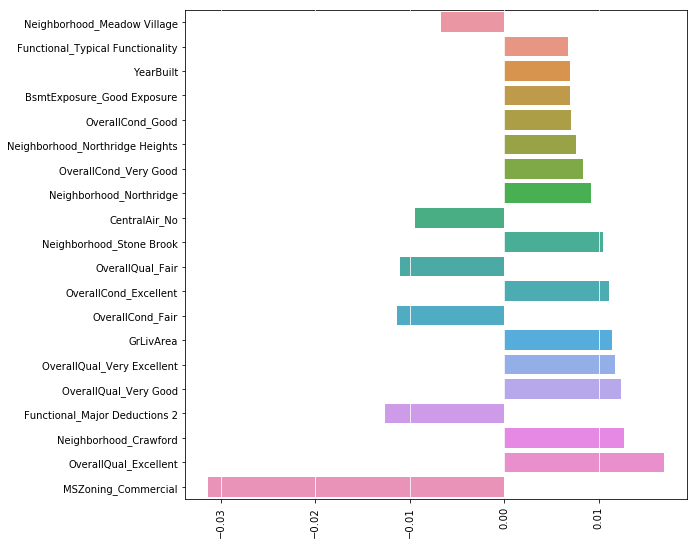

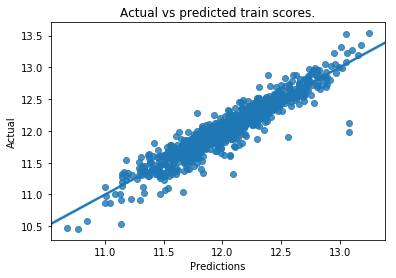

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


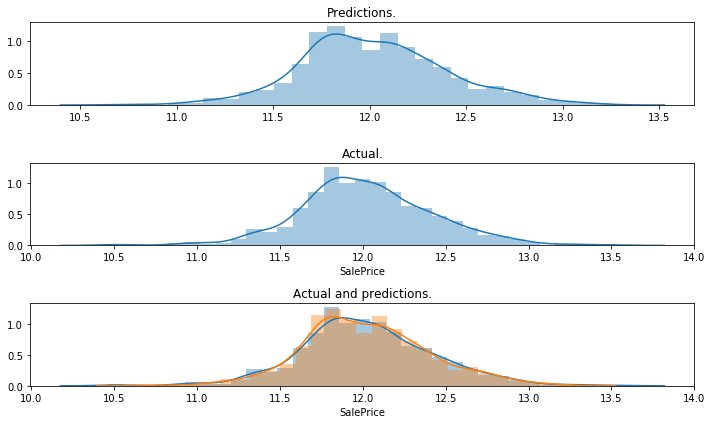

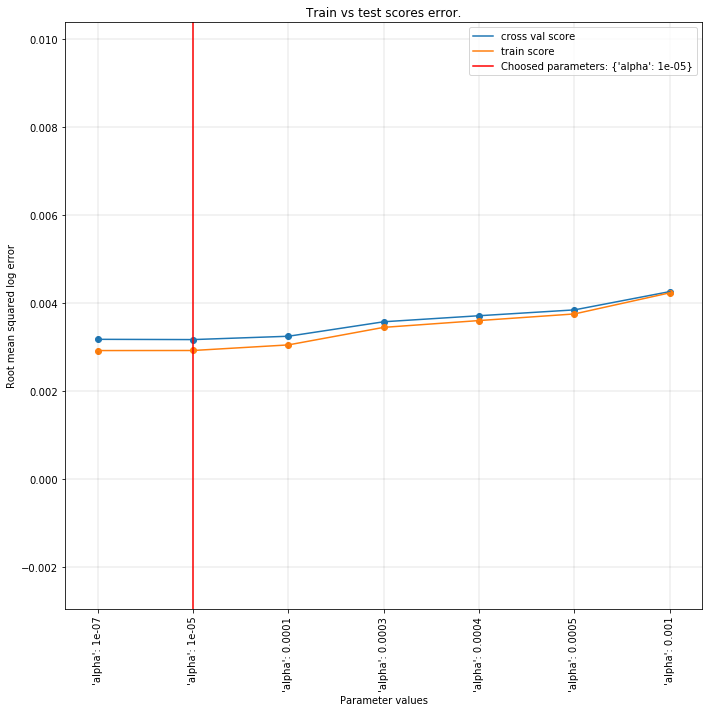

In [215]:
lasso_cols_selected.plot_results()

In [231]:
lasso_cols_selected.grid.predict(trainWithDummies.loc[:, best_85_quantile_cols])

array([ 2.58150868,  2.57099083,  2.58475616, ...,  2.59709369,
        2.54404624,  2.54781969])

In [236]:
ytrain.shape
lasso_cols_selected.test_predictions

(1460,)

,SalePrice
Id,
1461,11.639132
1462,11.884560
1463,12.156169
1464,12.118955
1465,12.229721
1466,12.118085
1467,12.036097
1468,12.060914
1469,12.178934


In [226]:
lasso_cols_selected.train_predictions - y

ValueError: operands could not be broadcast together with shapes (1168,) (1460,) 

In [84]:
from sklearn.model_selection import validation_curve
y = np.log1p(ytrain)

param_range = [1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3]
train_scores, test_scores = validation_curve(Lasso(normalize=False, max_iter=5000), trainWithDummies, y,
                 param_name='alpha',param_range=param_range,
                 n_jobs=-1, scoring='neg_mean_squared_log_error',cv=5)

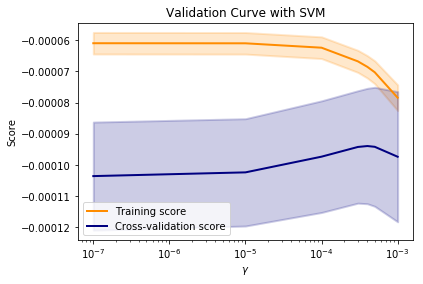

In [88]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [76]:
train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

pf = PolynomialFeatures(2)

train_number_type = get_number_types(train)
train_categoricals = get_categoricals(train)
train_number_type = pd.DataFrame(pf.fit_transform(train_number_type))

test_number_type = get_number_types(test)
test_categoricals = get_categoricals(test)
test_number_type = pd.DataFrame(pf.transform(test_number_type))

skewness = train_number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= .75].index

train_number_type.iloc[:, cols_to_log] = np.log1p(train_number_type.iloc[:, cols_to_log])

trainWithDummies, testWithDummies = get_df_for_predictions(number_type.join(train_categoricals), test_number_type.join(test_categoricals))

ValueError: operands could not be broadcast together with shapes (1459,595) (33,) (1459,595) 

In [31]:
train['priceBins'] = pd.cut(y.values, bins=bins)
train.head(2)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,OverallQual,PavedDrive,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities,priceBins
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,...,Good,Paved,No Pool,Standard (Composite) Shingle,Gable,Normal Sale,WD,Paved,"All public Utilities (E,G,W,& S)","(12.217, 12.656]"
2,80.0,9600.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,...,Above Average,Paved,No Pool,Standard (Composite) Shingle,Gable,Normal Sale,WD,Paved,"All public Utilities (E,G,W,& S)","(11.778, 12.217]"


In [34]:
train.groupby(by=['priceBins', 'Neighborhood', 'SaleCondition']).LotArea.describe()

count  \
priceBins        Neighborhood                          SaleCondition                                               
(10.457, 10.899] Brookside                             Normal Sale                                           2.0   
                 Iowa DOT and Rail Road                Abnormal Sale -  trade, foreclosure, short sale       2.0   
                                                       Normal Sale                                           1.0   
                 Old Town                              Abnormal Sale -  trade, foreclosure, short sale       1.0   
                                                       Normal Sale                                           1.0   
(10.899, 11.339] Briardale                             Normal Sale                                           1.0   
                 Brookside                             Normal Sale                                           8.0   
                 Edwards                               Abnormal Sale -  trade, foreclosure, short sale       2.0   
                                                       Adjoining Land Purchase                               2.0   
                                                       Normal Sale                                           9.0   
                 Iowa DOT and Rail Road                Abnormal Sale -  trade, foreclosure, short sale       2.0   
                                                       Allocation - two linked properties with separat...    1.0   
                                                       Normal Sale                                           4.0   
                 Meadow Village                        Normal Sale                                           5.0   
                 Northwest Ames                        Sale between family members                           1.0   
                 Old Town                              Abnormal Sale -  trade, foreclosure, short sale       2.0   
                                                       Normal Sale                                           4.0   
                 Sawyer                                Normal Sale                                           2.0   
                 Sawyer West                           Normal Sale                                           2.0   
                 South & West of Iowa State University Normal Sale                                           1.0   
(11.339, 11.778] Bluestem                              Normal Sale                                           1.0   
                 Briardale                             Abnormal Sale -  trade, foreclosure, short sale       3.0   
                                                       Normal Sale                                          11.0   
                                                       Sale between family members                           1.0   
                 Brookside                             Abnormal Sale -  trade, foreclosure, short sale       3.0   
                                                       Normal Sale                                          23.0   
                 Clear Creek                           Abnormal Sale -  trade, foreclosure, short sale       1.0   
                 College Creek                         Normal Sale                                          13.0   
                 Crawford                              Normal Sale                                           3.0   
                 Edwards                               Abnormal Sale -  trade, foreclosure, short sale       5.0   
...                                                                                                          ...   
(12.217, 12.656] Timberland                            Normal Sale                                          12.0   
                 Veenker                               Normal Sale                                           4.0   
(12.656, 13.095] Clear Creek                   

,L1,L2,type
0,5.130038,2.412919,"(12.217, 12.656]"
1,4.558967,-0.103930,"(11.778, 12.217]"
2,4.882688,2.964439,"(12.217, 12.656]"
3,4.347162,-0.501003,"(11.778, 12.217]"
4,4.718355,5.016448,"(12.217, 12.656]"


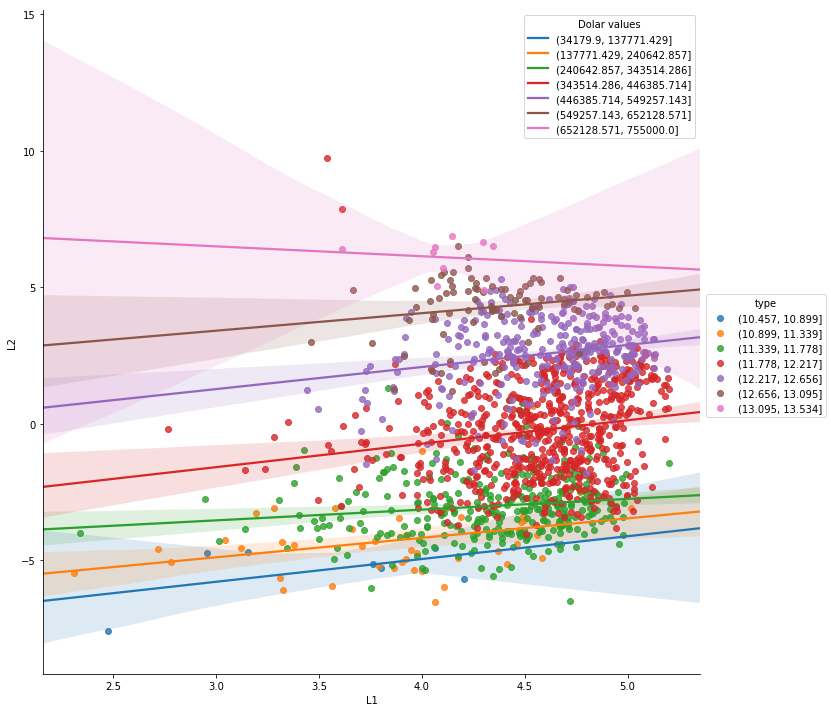

In [18]:
from sklearn.decomposition import TruncatedSVD
y = np.log1p(ytrain)
svd = TruncatedSVD()
bins = 7

svd_train = svd.fit_transform(trainWithDummies)
svd_train = pd.DataFrame(svd_train)
svd_train.columns = ['L1', 'L2']
svd_train['type'] = pd.cut(y.values, bins=bins)
svd_train.head()

sns.lmplot(data=svd_train, x='L1', y='L2', hue='type', size=10)

legend = list(pd.cut(ytrain, bins=bins).unique().sort_values(ascending=True))
plt.legend(legend, title='Dolar values')